In [19]:
from pathlib import Path
import torch
import numpy as np
from dataset import WHDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import metrics

In [20]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [21]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(420)
np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Controls the input generation

In [22]:
# Overall settings
out_dir = "out"

# System settings
nu = 1
ny = 1
batch_size = 32 # 256


# Compute settings
cuda_device = "cuda:0"
no_cuda = True
threads = 5
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")

In [23]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir / "ckpt_sim_wh.pt", map_location=device)
cfg = exp_data["cfg"]
# For compatibility with initial experiment without seed
try:
    cfg.seed
except AttributeError:
    cfg.seed = None

In [24]:
seq_len = cfg.seq_len_ctx + cfg.seq_len_new

In [25]:
# Create data loader
test_ds = WHDataset(nx=cfg.nx, nu=cfg.nu, ny=cfg.ny, seq_len=seq_len,
                    system_seed=system_seed, data_seed=data_seed, fixed_system=False)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=threads)

In [26]:
batch_y, batch_u = next(iter(test_dl))
batch_y = batch_y.to(device)
batch_u = batch_u.to(device)
with torch.no_grad():
    batch_y_ctx = batch_y[:, :cfg.seq_len_ctx, :]
    batch_u_ctx = batch_u[:, :cfg.seq_len_ctx, :]
    batch_y_new = batch_y[:, cfg.seq_len_ctx:, :]
    batch_u_new = batch_u[:, cfg.seq_len_ctx:, :]

In [27]:
batch_y_sim_full_rep = torch.load("batch_y_sim_full_rep.pt")

err_rep = batch_y_sim_full_rep - batch_y # error for all training repetitions R, B, T, C
err_rep_train = err_rep[:, :cfg.seq_len_ctx, :, :] # training error for all repetitions R, B, T, C
loss_rep = torch.mean(err_rep_train**2, dim=(2, 3)) # loss for all repetitions R, B, L
idx_best = torch.argmin(torch.nan_to_num(loss_rep, torch.inf),  dim=0) # idx of best training repetition per batch B
batch_y_sim_full_best = batch_y_sim_full_rep[idx_best, torch.arange(batch_size)] # best training repetition full sequence B, T, C

In [28]:
#batch_y_sim_new = batch_y_sim_full_rep[0, :, cfg.seq_len_ctx:, :] # best training repetition test sequence B, T, C
batch_y_sim_new = batch_y_sim_full_best[:, cfg.seq_len_ctx:, :] # best training repetition test sequence B, T, C

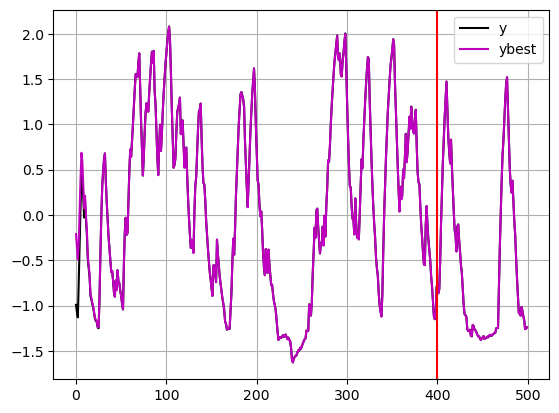

In [29]:
batch_idx = 2
rep_idx = 0

plt.plot(batch_y[batch_idx], 'k', label="y") # identification data
#plt.plot(batch_y_sim_full_rep[:, batch_idx, :, :].squeeze(-1).T, 'b')#, label="yall") # all models
#plt.plot(batch_y_sim_full_rep[rep_idx, batch_idx], 'r') # one model
plt.plot(batch_y_sim_full_best[batch_idx], 'm', label="ybest") # best model
#plt.plot(batch_y[batch_idx], 'k') # repetition of data
plt.legend()
plt.grid()
plt.axvline(cfg.seq_len_ctx, color='red')

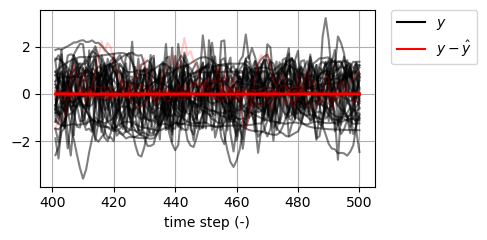

In [30]:
batch_sim_err = batch_y_new - batch_y_sim_new
t = np.arange(1, batch_u_new.shape[1]+1) + cfg.seq_len_ctx
plt.figure(figsize=(5, 2.5))
#plt.ylim([-3, 3])
plt.plot(t, batch_y_new.squeeze(-1).T, "k", alpha=0.5);
plt.plot(t, np.nan*np.zeros(t.shape), "k", alpha=1.0, label="$y$")
plt.plot(t, batch_sim_err.squeeze(-1).T, "r", alpha=0.2);
plt.plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y - \hat y$");
plt.grid(True)
plt.xlabel("time step (-)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig(fig_path / "wh_sim_batch_ml.pdf")

In [31]:
##%%
skip = 0
rmse_ml = metrics.rmse(batch_y_new.numpy(), batch_y_sim_new.numpy(), time_axis=1)

In [32]:
np.isnan(rmse_ml).sum()

0

In [33]:
rmse_ml = np.nan_to_num(rmse_ml, copy=True, nan=np.nanmean(rmse_ml))

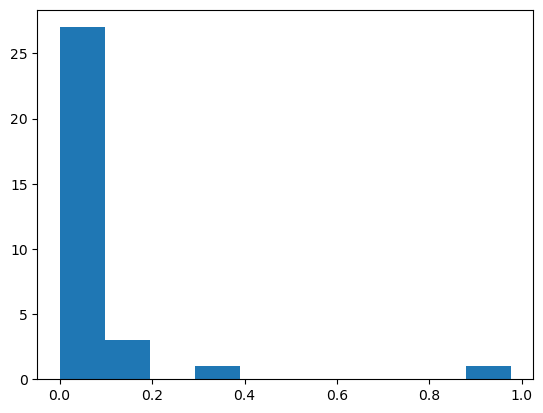

In [34]:
plt.hist(rmse_ml);

In [35]:
print(f'rmse: {rmse_ml.mean()}')

rmse: 0.06380351632833481


In [36]:
#rmse_ml[rmse_ml < 0.05]